# Bank Ticket Cancellation Rate Analysis
### Case Study

## 1. Python settings and data import

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_context('notebook')
sns.set_style('darkgrid')

In [2]:
#read the .db files and set them to respective dataframes
cust_cnx = sqlite3.connect(r'C:\Users\kristina.kostina\Downloads\DAcasestudy\Customers.db')
cust_df = pd.read_sql_query("SELECT * FROM Customers", cust_cnx, \
                            parse_dates =['account_created_date',\
                                          'birthdate_date',\
                                          'first_shipped_order_date',\
                                          'first_placed_order_date'])

oi_cnx = sqlite3.connect(r'C:\Users\kristina.kostina\Downloads\DAcasestudy\OrderItems.db')
oi_df = pd.read_sql_query("SELECT * FROM OrderItems", oi_cnx)

orders_cnx = sqlite3.connect(r'C:\Users\kristina.kostina\Downloads\DAcasestudy\Orders.db')
orders_df_flat = pd.read_sql_query("SELECT * FROM Orders", orders_cnx, parse_dates =['order_date','order_raw'])
#some analyses on Orders table will require the use of MultiIndex. That's why this initial table is denoted as _flat;
#orders_df will denote the multiindexed version of orders_df_flat

products_cnx = sqlite3.connect(r'C:\Users\kristina.kostina\Downloads\DAcasestudy\Products.db')
products_df = pd.read_sql_query("SELECT * FROM Products", products_cnx, \
                                parse_dates =['collection_real_launch_date_date',\
                                              'product_first_order_date'])

In [4]:
#ensure that the imports worked, take a first look at the data
cust_df.head()

,user_id,account_created_date,age,gender,signup_channel,signup_device_type,signup_ip_address,signup_store_id,shipping_address_country,shipping_address_state,...,shipping_address_zip,birthdate_date,first_shipped_order_device_type,first_shipped_order_order_channel_code_online,first_shipped_order_order_retail_type_level_2,first_shipped_order_date,first_placed_order_date,first_placed_order_device_type,first_placed_order_order_channel_code_online,first_placed_order_order_retail_type_level_2
0,89256,NaT,35,,,,,0,Brasil,SP,...,01535000,1983-05-28,desktop,WEB,Online,2016-03-06,2016-03-06,desktop,WEB,Online
1,88350,NaT,44,,,,,0,Brasil,SP,...,18080709,1974-09-10,,WEB,Online,2015-09-06,2015-09-06,,WEB,Online
2,89688,NaT,57,,,,,0,Brasil,RS,...,98995000,1961-12-28,desktop,WEB,Online,2016-06-23,2016-06-23,desktop,WEB,Online
3,90364,NaT,61,,,,,0,Brasil,SP,...,16050640,1958-01-22,desktop,WEB,Online,2016-03-11,2016-03-11,desktop,WEB,Online
4,127080,NaT,34,F,,,,0,Brasil,SP,...,04542001,1984-11-22,desktop,WEB,Online,2015-12-04,2013-07-18,,-,Online


In [5]:
oi_df.head()

,order_item_id,order_id,sku,promotional_price,original_price,items_quantity,product_cost,is_item_sold_with_discount
0,328703,1594409,2195_73_0_M,257.98,351.88,1,79.53,t
1,328702,1594409,2881_147_0_M,211.03,281.46,1,102.44,t
2,328700,1594409,4097_263_0_G,175.82,234.51,1,75.10,t
3,328701,1594409,5403_1000026_0_U,117.14,117.14,1,37.54,f
4,342375,1652797,2967_1000058_0_M,174.23,348.72,1,117.15,t


In [6]:
orders_df_flat.head()

,id,store_id,user_id,order_date,order_raw,device_type,order_channel_code_online,order_retail_type,order_status,order_source_and_device,...,is_purchase_of_new_buyer,utm_medium,utm_source,utm_campaign,shipping_paid_by_amaro,shipping_paid_by_customer,order_subtotal,order_discount,shipping_cost,order_total
0,1594409,2,82,2016-02-02,2016-02-02 17:34:30,desktop,GSL,Physical,DELIVERED,desktop web,...,Returning Buyer Purchase,(none),(direct),,34.98,0.00,761.96,0.00,34.98,324.60
1,1652797,4,82,2016-02-21,2016-02-21 17:02:24,desktop,GSL,Physical,DELIVERED,desktop web,...,Returning Buyer Purchase,organic,google,,24.68,0.00,485.31,0.00,24.68,194.70
2,1754030,1,772,2016-03-23,2016-03-23 23:13:38,desktop,WEB,Online,DELIVERED,desktop web,...,Returning Buyer Purchase,newsletter,email,,45.36,0.00,2701.98,0.00,45.36,1084.00
3,3789151,1,772,2016-04-04,2016-04-04 00:00:00,,TRO,Online,DELIVERED,millennium,...,Same Month Returning Buyers,,,,0.00,21.41,328.40,0.00,9.12,149.02
4,1582210,2,864,2016-01-29,2016-01-29 16:05:04,desktop,WEB,Online,DELIVERED,desktop web,...,Same Month Returning Buyers,organic,google,,17.47,0.00,211.38,0.00,17.47,84.80


In [7]:
products_df.head()

,sku,category_1_name,category_2_name,category_3_name,category_4_name,category_5_name,collection_real_launch_date_date,product_first_order_date,descricao_cor,familia_cor_nome
0,1003_1000038_0_GG,Feminino,Moda,Roupas,Jaquetas & Casacos,Casacos,1969-12-31,2015-06-04,CINZA,CINZA
1,1019_40130843_0_G,Feminino,Acessórios,Meia-Calça,,,2015-05-04,2015-07-30,PRETO,PRETO
2,1035_1000070_0_U,Feminino,Acessórios,Chapéus,Aba Larga,,2016-02-29,2015-05-06,BURGUNDY,VERMELHO
3,1037_1000034_0_U,Feminino,Acessórios,Chapéus,Aba Larga,,2016-05-02,2016-05-24,ROXO,ROXO
4,1037_1000038_0_U,Feminino,Acessórios,Chapéus,Aba Larga,,2016-05-02,2016-05-20,CINZA,CINZA


In [102]:
#check the dataset sizes, data types and parsing: 
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30293 entries, 0 to 30292
Data columns (total 21 columns):
user_id                                          30293 non-null object
account_created_date                             29668 non-null datetime64[ns]
age                                              30270 non-null float64
gender                                           30293 non-null object
signup_channel                                   30293 non-null object
signup_device_type                               30293 non-null object
signup_ip_address                                30293 non-null object
signup_store_id                                  30293 non-null object
shipping_address_country                         30293 non-null object
shipping_address_state                           30293 non-null object
shipping_address_city                            30293 non-null object
shipping_address_zip                             30293 non-null object
birthdate_date                

In [333]:
#oi_df.info()
oi_df.describe(include='all')

,order_item_id,order_id,sku,promotional_price,original_price,items_quantity,product_cost,is_item_sold_with_discount,profit_margin
count,136774,136774,136774,135978.000000,136518.000000,136774,136774.000000,136774,135725.000000
unique,136774,61467,10157,NaN,NaN,18,NaN,3,NaN
top,314524,3518584,4047_1000054_0_U,NaN,NaN,1,NaN,f,NaN
freq,1,90,141,NaN,NaN,134023,NaN,82586,NaN
mean,NaN,NaN,NaN,272.164525,317.355360,NaN,99.099680,NaN,0.573449
std,NaN,NaN,NaN,159.037737,142.485474,NaN,52.538492,NaN,0.294758
min,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,NaN,-3.983228
25%,NaN,NaN,NaN,140.610000,211.030000,NaN,58.780000,NaN,0.532537
50%,NaN,NaN,NaN,257.980000,328.400000,NaN,95.300000,NaN,0.654189
75%,NaN,NaN,NaN,375.350000,398.830000,NaN,132.110000,NaN,0.714068


In [10]:
orders_df_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61499 entries, 0 to 61498
Data columns (total 34 columns):
id                                  61499 non-null object
store_id                            61499 non-null object
user_id                             61499 non-null object
order_date                          61499 non-null datetime64[ns]
order_raw                           61499 non-null datetime64[ns]
device_type                         61499 non-null object
order_channel_code_online           61499 non-null object
order_retail_type                   61499 non-null object
order_status                        61499 non-null object
order_source_and_device             61499 non-null object
payment_method                      61499 non-null object
payment_num_installments            61499 non-null object
payment_coupon                      61499 non-null object
shipping_method_id                  61499 non-null object
address_city                        61499 non-null object
addre

In [11]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10482 entries, 0 to 10481
Data columns (total 10 columns):
sku                                 10482 non-null object
category_1_name                     10482 non-null object
category_2_name                     10482 non-null object
category_3_name                     10482 non-null object
category_4_name                     10482 non-null object
category_5_name                     10482 non-null object
collection_real_launch_date_date    10482 non-null datetime64[ns]
product_first_order_date            10482 non-null datetime64[ns]
descricao_cor                       10482 non-null object
familia_cor_nome                    10482 non-null object
dtypes: datetime64[ns](2), object(8)
memory usage: 819.0+ KB


After taking the first look at the imported data, I realized that the columns that contain numerical data and dates weren't actually parsed as such (despite the fact that the default of **coerce_float** parameter in **read_sql_query** is set to True). It was after that that I've 1) included the **parse_dates** parameter into the function above 2) coerced the integers and floats here:

In [5]:
cust_df.age = pd.to_numeric(cust_df.age)

orders_df_flat.payment_num_installments = pd.to_numeric(orders_df_flat.payment_num_installments)
orders_df_flat.days_until_next_placed_order = pd.to_numeric(orders_df_flat.days_until_next_placed_order)
orders_df_flat.shipping_paid_by_amaro = pd.to_numeric(orders_df_flat.shipping_paid_by_amaro)
orders_df_flat.shipping_paid_by_customer = pd.to_numeric(orders_df_flat.shipping_paid_by_customer)
orders_df_flat.order_subtotal = pd.to_numeric(orders_df_flat.order_subtotal)
orders_df_flat.order_discount = pd.to_numeric(orders_df_flat.order_discount)
orders_df_flat.shipping_cost = pd.to_numeric(orders_df_flat.shipping_cost)
orders_df_flat.order_total = pd.to_numeric(orders_df_flat.order_total)

oi_df.promotional_price = pd.to_numeric(oi_df.promotional_price)
oi_df.original_price = pd.to_numeric(oi_df.original_price)
oi_df.product_cost = pd.to_numeric(oi_df.product_cost)

## 2. Data preparation and assumptions
### 2.1. Dealing with outliers in data

Let's take a look at the data to see the potential for data cleaning.  I will start with **Orders** as it's clear that this is the fact table of the set.

In [6]:
#basic descriptive statistics of the Orders dataset
orders_df_flat.describe(include='all').transpose()

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
id,61499,61499,1713924,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_id,61499,10,1,50741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,61499,30302,28,2944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_date,61499,183,2016-06-09 00:00:00,795,2016-01-01 00:00:00,2016-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_raw,61499,51319,2016-05-18 00:00:00,116,2016-01-01 01:52:03,2016-07-01 23:32:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_type,61499,4,desktop,39038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_channel_code_online,61499,11,WEB,44839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_retail_type,61499,3,Online,50887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_status,61499,6,DELIVERED,46879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_source_and_device,61499,5,desktop web,39038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Orders data contains 61499 orders (data quality check - all orders have unique ids) of 30302 unique customers, in the period of January through June 2016. (The data on July will be ignored since we only have the observations of one day in that month, very likely added to the dataset in question by mistake).

#### Order Subtotal
At first glance, data does look as if it might have some outliers. For instance, maximum *order subtotal* - 30685, doesn't look very realistic, neither does the maximum *order total* of 13072 or *order discount* of 8929. To check the data for outliers, I will build a box and whiskers plot.

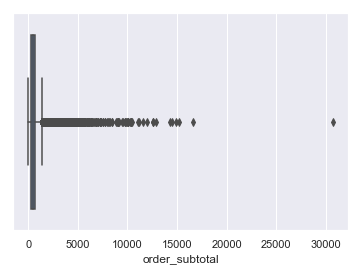

In [14]:
sns.boxplot(orders_df_flat.order_subtotal)

There are really lots of observations lying outside the Q3 + 1.5 interquartile range on the right-hand side of the dataset (represented by the end of the error bar in the default Boxplot in Seaborn - Tukey boxplot). 
Starting from around point 14 000 in *order subtotal* there are outliers, and within that there lie suspected outliers.
First, let's try to exclude them all:

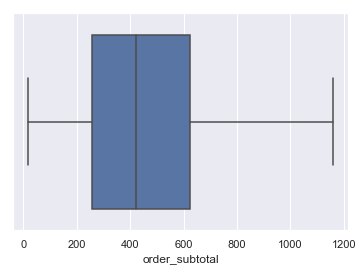

In [15]:
#after a couple of tests I arrived to an approximate end of the 1.5 IQR:
sns.boxplot(orders_df_flat[orders_df_flat.order_subtotal<1160].order_subtotal)

In [16]:
#see the values of orders_total at different quantiles:
orders_df_flat.order_subtotal.quantile([0.25,0.5,0.75,0.9,0.999])

0.250     273.94000
0.500     445.77000
0.750     703.75000
0.900    1149.52000
0.999    6288.09198
Name: order_subtotal, dtype: float64

Even though there are so many observations lying outside of the 1.5 of IQR, the 99.9% of all orders still have the *subtotal* of below 6288 reais. <br>
To identify the threshold for cutting out the outliers, let's first see how many orders will be classified as outliers if we follow the 1.5 IQR logic:

In [7]:
orders_df_flat[orders_df_flat.order_subtotal>=1160].order_subtotal.count()

6108

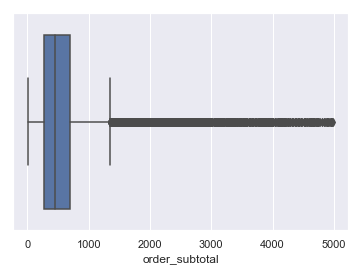

In [18]:
#That's a really big share of all orders. Let's take a look at the boxplot while including more observations:
sns.boxplot(orders_df_flat[orders_df_flat.order_subtotal<5000].order_subtotal)

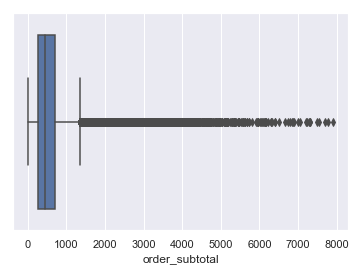

In [19]:
#Till the order total of 5000, the 'suspected outliers' lie so frequently that even represent a continuous line
#Let's take a look at a higher treshold:
sns.boxplot(orders_df_flat[orders_df_flat.order_subtotal<8000].order_subtotal)

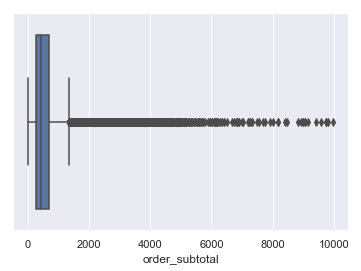

In [20]:
sns.boxplot(orders_df_flat[orders_df_flat.order_subtotal<10000].order_subtotal)

It looks like the orders below 5000 can't be treated as outliers, but probably those above 8000 can be. <br> I'll exclude those values to avoid large skews in the data.<br>
But before that, I'll see whether there are any particular customers that are responsible for these outlying orders:

In [9]:
orders_df_flat[orders_df_flat.order_subtotal>=10000].user_id.value_counts().head()

Series([], Name: user_id, dtype: int64)

In [10]:
orders_df_flat[orders_df_flat.order_subtotal>=3000].user_id.value_counts().head()

32725308    28
32736602     7
32718280     7
32704908     5
32755624     5
Name: user_id, dtype: int64

The majority of 'exceptional' purchases continue to belong to just one particular customer at different levels of tolerance. <br> 
Let's see whether this customer's purchases will be important for the purposes of this analysis:

In [23]:
orders_df_flat[orders_df_flat.user_id=='32725308'].groupby('order_status').payment_method.value_counts()

order_status  payment_method
CANCELLED     Boleto            68
DELIVERED     Cartão             2
Name: payment_method, dtype: int64

In [24]:
#out of all purchases of this customer, most were cancelled and were passed via Boleto!\
#this kind of customer certainly would skew our data when analyzing the Boleto cancellation rate. \
#Let's explore more details of his/her purchases
noia_df = pd.merge(orders_df_flat[orders_df_flat.user_id=='32725308'],oi_df,left_on='id',right_on='order_id')
noia_df.sku.value_counts()

4399_275_0_44         19
959_1000012_0_44      17
6495_1000108_0_42     15
5923_83_0_G           15
5199_40130843_0_42    14
5217_40130843_0_42    14
6487_40130843_0_42    13
5207_1000032_0_42     13
6243_1000070_0_42     13
5923_40130843_0_G     12
6495_40130843_0_42    12
2317_1000024_0_G      11
2791_1000022_0_44     11
5211_40130843_0_42     9
5223_1000032_0_42      9
3819_1000094_0_44      8
4079_1000058_0_42      8
4401_275_0_G           8
3819_233_0_44          8
5257_40130843_0_42     8
959_83_0_42            8
959_1000032_0_42       7
6493_385_0_42          7
4467_1000030_0_G       7
4079_1000058_0_40      7
3769_1000058_0_42      7
3769_40130843_0_44     6
793_1000032_0_42       6
6493_135_0_42          6
2221_1000010_0_44      6
                      ..
4391_1000032_0_42      1
7133_1000058_0_G       1
793_1000012_0_42       1
771_1000038_0_G        1
2901_31_0_G            1
771_1000070_0_G        1
4131_40130843_0_G      1
5855_40130843_0_42     1
4103_233_0_42          1


It appears rather suspectful that, first, many *sku*s appear in several orders, second, that the sizes vary from M to GG. This appears as an attempt of fraud. Further investigation might be needed, which goes outside the scope of the current analysis. <br> For now, let's exclude this customer from the analysis to avoid the skew in the data. <br>
I'll also exclude the customers whose subtotal of orders is above 8000, based on the visualizations of outliers seen in the boxplots above.

In [6]:
orders_df_flat = orders_df_flat.drop(orders_df_flat[orders_df_flat.order_subtotal>8000].index)

In [7]:
orders_df_flat = orders_df_flat.drop(orders_df_flat[orders_df_flat.user_id=='32725308'].index)
orders_df_flat.describe(include='all').transpose()

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
id,61409,61409,1918898,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_id,61409,10,1,50653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,61409,30294,28,2944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_date,61409,183,2016-06-09 00:00:00,795,2016-01-01 00:00:00,2016-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_raw,61409,51232,2016-05-18 00:00:00,116,2016-01-01 01:52:03,2016-07-01 23:32:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_type,61409,4,desktop,39023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_channel_code_online,61409,11,WEB,44752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_retail_type,61409,3,Online,50799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_status,61409,6,DELIVERED,46867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_source_and_device,61409,5,desktop web,39023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With some outlying observations excluded, the table looks slighly more realistic. <br>Let's see whether there are still some outliers in other metrics.

#### Order total

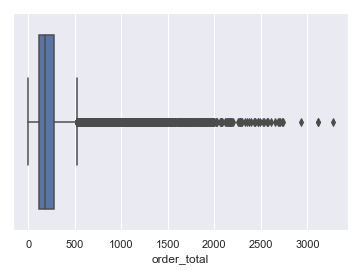

In [26]:
sns.boxplot(orders_df_flat.order_total)

0

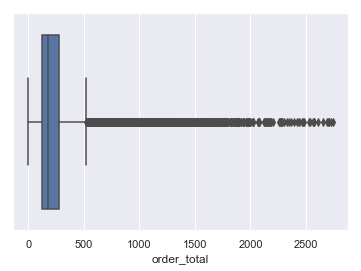

In [51]:
#Looks like there might be some outliers outside the ~2800 total sum of order.
sns.boxplot(orders_df_flat[orders_df_flat.order_total<2800].order_total)
orders_df_flat[orders_df_flat.order_total>2800].order_total.count()

There are four observations that are very obvious outliers.
<br> As for all suspected outliers lying within the range starting from Q3 + 1.5 IQR and till more or less the 2800 order total, we'll keep them in, following the same logic as for order subtotal. Excluding these orders from the analysis would have resulted in a significant loss of data.

In [8]:
orders_df_flat = orders_df_flat.drop(orders_df_flat[orders_df_flat.order_total>2800].index)

### 2.2. Key dimensions
#### Payment method
In this Case Study, we need to analyze the cancellation rate of the orders for which payment method is 'Boleto'.
Let's first see what payments methods look like in the Orders table:

In [11]:
#check payment methods and their occurencies:
orders_df_flat.payment_method.value_counts()

Cartão                  31859
Boleto                  16434
DEVOLUÇÃO TROCA          3834
Créditos Troca           1406
N/A                      1402
Débito                   1094
REDE-CREDITO A VISTA     1086
VISA A VISTA              577
MAESTRO A VISTA           574
CORTESIA                  548
ELECTRON A VISTA          509
Pós-pago                  466
MASTERCARD A VISTA        443
VISA CREDITO              236
MASTERCARD CREDITO        235
BOLETO                    113
MASTERCARD BOLETO          81
ELO DEBITO A VISTA         66
REDE-CREDITO 2X            61
AMEX A VISTA               49
MASTERCARD 2X              45
REDE-CREDITO 3X            45
CRÉDITOS AMARO             35
VISA 2X                    32
MASTERCARD 3X              31
REDE-CREDITO 4X            25
VISA 3X                    21
AMEX CREDITO               17
REDE-CREDITO 5X            16
REDE-CREDITO 6X            16
MASTERCARD 6X              15
DINERS A VISTA             10
MASTERCARD 4X               8
VISA 6X   

'Boleto' and 'BOLETO' appear as if they were two different payment methods. Maybe they aren't recorded properly in one of the devices / order channels. But this isn't important for this analysis, where we can assume it's the same payment method.

In [9]:
#join together the capitalizations 'BOLETO' into 'Boleto', rewrite directly in the 'payment_method' column:
orders_df_flat.payment_method = orders_df_flat.payment_method.apply(lambda x: x.title())
#check:
orders_df_flat.payment_method.value_counts().head(15)

Cartão                  31855
Boleto                  16497
Devolução Troca          3834
Créditos Troca           1406
N/A                      1401
Débito                   1094
Rede-Credito A Vista     1086
Visa A Vista              577
Maestro A Vista           574
Cortesia                  548
Electron A Vista          509
Pós-Pago                  466
Mastercard A Vista        443
Visa Credito              236
Mastercard Credito        235
Name: payment_method, dtype: int64

#### Order Status
According to the task, the two flags *is_placed_order* and *is_shipped order* should be reflected in *order status*. Let's check whether it's registered properly:

In [10]:
#see the counts of all possible combinations and their occurencies:
orders_df_flat.groupby(['order_status','is_placed_order'])['is_shipped_order'].value_counts()

order_status                   is_placed_order  is_shipped_order
AWAITING PAYMENT CONFIRMATION  t                f                      13
BILLED / READY TO BE SHIPPED   f                f                      91
                               t                t                     534
CANCELLED                      f                f                     640
                               t                f                   10031
DELIVERED                      f                f                    4197
                               t                t                   42667
PAYMENT CONFIRMED              f                f                       2
SHIPPED                        f                f                      76
                               t                t                    3154
Name: is_shipped_order, dtype: int64

It's clear that not all combinations of flags *is_placed_order* and *is_shipped_order* reflect exactly what's described in the task. In particular, there are 4199 orders that have the status **delivered**, but weren't neither placed not shipped (**f - f**). Also, there are 640 orders that were cancelled but appear as **f - f** and not **t - f**. Since both cases represent a rather large fraction of all delivered and cancelled orders respectively, they need to be analised further to avoid a potential bias in the analysis.

In [11]:
#fetch description of data that falls out of the indicated order:
orders_df_flat[(orders_df_flat.order_status=='CANCELLED')
               &(orders_df_flat.is_placed_order=='f')
               &(orders_df_flat.is_shipped_order=='f')].describe(exclude='number').transpose()

,count,unique,top,freq,first,last
id,640,640,3815584,1,NaN,NaN
store_id,640,1,1,640,NaN,NaN
user_id,640,563,32866266,5,NaN,NaN
order_date,640,139,2016-05-11 00:00:00,11,2016-01-04 00:00:00,2016-07-01 00:00:00
order_raw,640,139,2016-05-11 00:00:00,11,2016-01-04 00:00:00,2016-07-01 00:00:00
device_type,640,1,,640,NaN,NaN
order_channel_code_online,640,5,TRO,620,NaN,NaN
order_retail_type,640,1,Online,640,NaN,NaN
order_status,640,1,CANCELLED,640,NaN,NaN
order_source_and_device,640,1,millennium,640,NaN,NaN


Out of 640 cases under consideration, 565 don't have the payment_method (**N/A**), 620 have the *order_channel_code_online* **TRO**. My guess is that we're dealing with Cancelled orders that were actually not new orders, but Exchanges (Troca). Let's see what other orders with *order_channel_code_online* **TRO** look like:

In [12]:
orders_df_flat[(orders_df_flat.order_channel_code_online=='TRO')].payment_method.value_counts()

Devolução Troca    3803
N/A                 548
Boleto               13
Cortesia             12
Name: payment_method, dtype: int64

Indeed, the majority of **TRO** orders fall into category **Devolução Troca** in *payment_method*. I will assume that we're dealing with orders that were supposed to make part of the 'Returns and Exchanges' category but for some reason weren't labelled as such. To confirm, let's see the order status that have the payment method of **Devolução Troca** and are tagged as **f - f**.

In [13]:
orders_df_flat[(orders_df_flat.payment_method=='Devolução Troca')
               &(orders_df_flat.is_placed_order=='f')
               &(orders_df_flat.is_shipped_order=='f')].order_status.value_counts()

DELIVERED    3746
CANCELLED      63
Name: order_status, dtype: int64

It appears that the orders with the payment method **Devolução Troca** are registered separately from the initial order that is being exchanged, otherwise, it wouldn't make sense to flag it with **f - f** in placing and shipping. <br> Therefore, it might make sense to exclude these orders from our analysis, given that they don't affect the KPIs of the task - GMV and Revenue (calculated in the next section).

### 2.3. Adding new fields important for analysis
#### AMARO Revenue KPIs

In [14]:
#calculate GMV and add it to the dataframe as a new field. 
#According to the task, GMV is the sum of the column order_total when is_placed_order is true
orders_df_flat['gmv'] = orders_df_flat[orders_df_flat.is_placed_order=='t'].order_total
#fill the NaN Values with zeros
orders_df_flat.gmv.fillna(value=0, inplace=True)

In [15]:
#calculate revenue = sum of the column order_total when is_shipped_order = true
orders_df_flat['revenue'] = orders_df_flat[orders_df_flat.is_shipped_order=='t'].order_total
#fill the NaN Values with zeros
orders_df_flat.revenue.fillna(value=0, inplace=True)

#### Other useful fields

In [16]:
#In order to always be able to separate the purchases paid with bank tickets from all others, let's create a boolean field:
orders_df_flat['payment_method_b'] = np.where(orders_df_flat['payment_method']=="Boleto",True,False)

In [17]:
#also, it might be helpful to have all Orders rank ordered for each customer. I'll do this with a window function:
orders_df_flat = (orders_df_flat.assign(rn=orders_df_flat.groupby(['user_id'])['order_raw']\
                                        .rank(method='first', ascending=True))).sort_values(['user_id','rn'])

In [18]:
#let's create a field order month to facilitate grouping when analyzing dynamics
orders_df_flat['order_month'] = orders_df_flat.order_date.map(lambda x: x.strftime('%m'))

In [19]:
#let's create a multiindex based on user_id and the rank order of each order to facilitate future indexing:
orders_df = orders_df_flat.reset_index(drop=True).set_index(['user_id','rn'])

## 3. Data Analysis
### 3.1 Cancellation rate dynamics. The importance of analyzing the cancellation rate of bank tickets.

#### Cancellation Rate

There are two approaches to the calculation of cancellation rate: customer-based and order-based. Traditionally, the most common one in Marketing is the customer-based approach: cancellation rate as a percentage of customers who cancel in any given month compared to total (paying) customers.<br>
However, since we're dealing with a situation where each customer can have both delivered and cancelled orders within each given month, we'd rather apply the order-based approach. <br>
Therefore, here we calculate the cancellation rate based on orders themselves: **percentage of cancelled orders in any given month compared to total orders of that month.**

In [31]:
#calculate the overall monhtly cancellation rate
#Last month (July) dropped to avoid confusion - we only have orders of one day in July
cancel_rate = orders_df.groupby('order_month').order_status\
.value_counts(normalize=True).unstack().transpose().loc['CANCELLED'][:-1]
cancel_rate

order_month
01    0.194786
02    0.196093
03    0.167088
04    0.171833
05    0.169146
06    0.160834
Name: CANCELLED, dtype: float64

In [166]:
#let's see the cancellation rate of bank tickets. Last month (July) dropped.
cancel_rate_b = orders_df[orders_df.payment_method_b==True].groupby('order_month').order_status\
.value_counts(normalize=True).unstack().transpose().loc['CANCELLED'][:-1]
cancel_rate_b

order_month
01    0.553272
02    0.564616
03    0.544817
04    0.524027
05    0.527905
06    0.528083
Name: CANCELLED, dtype: float64

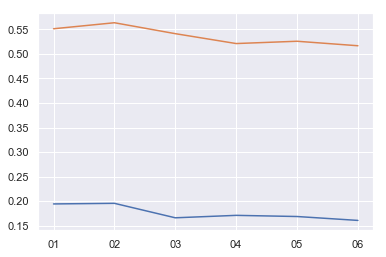

In [56]:
sns.lineplot(markers=True, data=cancel_rate, legend="full")
sns.lineplot(markers=True, data=cancel_rate_b, legend="full")

Cancellation rate for bank tickets is significantly higher than the average of all orders.<br>
Around half of all bank ticket orders is not shipped. <br>
Also, it's possible to spot a tendency to decrease in both curves.

#### Bank ticket share
Let's now see which share of all orders bank tickets represent.

order_month
01    0.270797
02    0.307251
03    0.252593
04    0.284744
05    0.256774
06    0.243931
Name: Boleto, dtype: float64

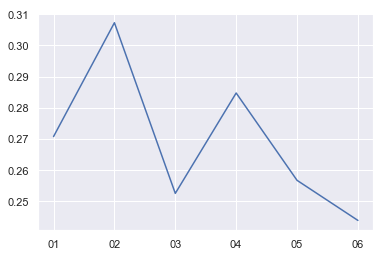

In [167]:
boleto_share = orders_df.groupby('order_month').payment_method\
.value_counts(normalize=True).unstack().transpose().loc['Boleto'][:-1]
sns.lineplot(markers=True, data=boleto_share, legend="full")
boleto_share

During the period Jan-Jul 2016, bank ticket was a chosen method of payment in ~27% of cases, with its share slightly fluctuating across months.

#### GMV dynamics
Let's now see how the bank tickets and other payment methdods are represented in GMV and how this metric changes over time.

payment_method_b,False,True
order_month,,
01,948663.82,375598.05
02,1141055.02,498427.18
03,1233419.56,483031.89
04,1620379.23,629897.48
05,2281532.03,779308.07
06,2516413.91,884722.64


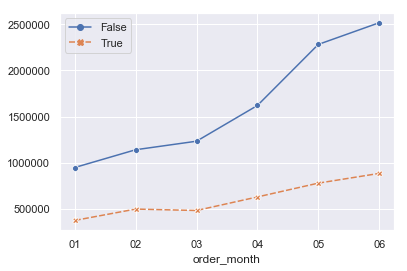

In [38]:
#Dynamics of GMV from different payment methods
gmv_dyn = orders_df_flat.groupby(['order_month','payment_method_b']).sum().unstack().gmv[:-1]
sns.lineplot(markers=True, data=gmv_dyn, legend="full")
gmv_dyn

We can see that bank tickets payments represent a rather large share in GMV. Also, it's important to see that the growth of GMV from bank tickets doesn't keep up with the growth of GMV across all other payment methods, resulting in an increasing gap between such. We might further check a hypothesis that probably the customers that use bank tickets are always the same ones, as opposed to the growing number of customers preferring other payment methods.

#### Payment methods share in cancelled orders
And finally, let's see how different payment methods make part in all cancelled orders.

In [173]:
cancel_rate_all = orders_df.groupby(['order_month','order_status']).payment_method.value_counts(normalize=True)\
.unstack()[:-1].xs('CANCELLED', level='order_status')
cancel_rate_all[:-1].transpose().dropna(thresh=1)

order_month,01,02,03,04,05,06
payment_method,,,,,,
Boleto,0.769057,0.885808,0.823664,0.869684,0.801860,0.801020
Cartão,0.133585,0.039152,0.021374,0.025082,0.028837,0.039889
Créditos Amaro,NaN,NaN,NaN,NaN,0.000930,0.001391
Créditos Desconto,NaN,NaN,NaN,0.000545,NaN,NaN
Créditos Troca,0.003774,0.001631,0.000763,0.000545,0.000465,0.000464
Devolução Troca,0.004528,0.005438,0.007634,0.004907,0.008372,0.003711
Débito,0.003019,NaN,NaN,0.000545,0.000465,0.000928
N/A,0.086038,0.053834,0.110687,0.063795,0.109302,0.091837
Pós-Pago,NaN,0.014138,0.035878,0.034351,0.049302,0.060761


Out of all cancellations, bank tickets represented about 82% in all months!

#### Lost Revenue estimate
Let's calculate how much revenue is hypothetically being lost monthly due to bank ticket cancellation.
<br> For the simplicity of calculation, I'll deal with a rough assumption that each cancelled bank ticket results in lost revenue, which contradicts the hypothesis that some of cancelled orders are later being replaced.
<br> To find the lost revenue estimate, I'll find the monthly sum of GMV for cancelled orders, since this metric represents the order total of orders that were placed but were not shipped.

order_month
01    62397.33
02    28441.25
03    24797.97
04    37262.04
05    68817.87
06    73334.17
Name: gmv, dtype: float64

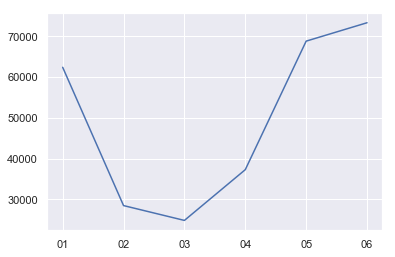

In [36]:
lost_rev = orders_df_flat[(orders_df_flat.order_status=='CANCELLED')&\
               (orders_df_flat.payment_method!='Boleto')].\
groupby('order_month').gmv.sum()[:-1]
sns.lineplot(markers=True, data=lost_rev, legend="full")
lost_rev

In [34]:
lost_rev.mean()

327940.78500000027

In [62]:
lost_rev / orders_df_flat.groupby('order_month').revenue.sum()[:-1].mean()

0.17679146652218702

The cancelled orders with bank tickets as a payment method might potentially be resulting in ~**R$ 328 th** lost revenue, which equals **18%** of all monthly revenue. Moreover, lost revenue grows significantly over the observed period, more than doubling the monthly sum when comparing the first and last months.
<br><br>
**All of the mentioned demonstrates the importance of analyzing the cancellation rate of orders paid by bank tickets.**

## 3.2. Hypotheses of analysis

### Hypothesis 1. The customers that pay with bank tickets are, generally, the same ones.
#### Analysis of the proportion of the preferred *payment method* - either **bank ticket** or any other method.<br>
For this purpose, let's see: <br> 1) with which frequency each customer uses either bank ticket or any other payment method, <br> 2) do a reverse value counting, seeing which level of bank ticket usage is more common: more equal ones (50/50 and around), or more inclined towards one payment method (100/0 and around).

In [96]:
#find number of users in each group of 'level of bank ticket usage'
orders_df_flat.groupby(['user_id']).payment_method_b.value_counts(
    normalize=True).unstack()[True].fillna(value=0).value_counts(normalize=True, bins=8)

(-0.002, 0.125]    0.696696
(0.875, 1.0]       0.227808
(0.375, 0.5]       0.032648
(0.625, 0.75]      0.012841
(0.25, 0.375]      0.012181
(0.125, 0.25]      0.010563
(0.75, 0.875]      0.003994
(0.5, 0.625]       0.003268
Name: True, dtype: float64

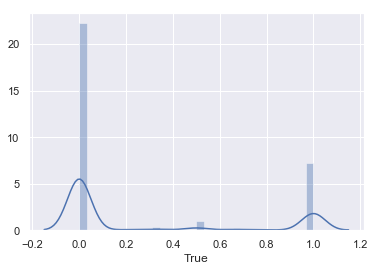

In [103]:
grouped_b = orders_df_flat.groupby(['user_id']).payment_method_b.value_counts(normalize=True).unstack()[True].fillna(value=0)
sns.distplot(grouped_b)

We can see that 70% of users almost don't use bank tickets (~ use them in 0 to 12,5% of cases). At the same time, there is a group of 23% of all users that, on the contrary, almost always use bank tickets - in 87,5-100% of cases.<br>
That gives us 93% of all users that are devoted to either paying with bank tickets, or using other payment methods. <br>

With that, we can say that the customers that prefer to use bank tickets, in most cases, are the same ones.<br>
This is a very important observation, since it gives us the right to compare customer properties of the two groups separately, without deepening the analysis to the level of orders with different payment methods of each customer.<br>
That is, in the mejority of further exercises, I'll be directly comparing groups 'True' and 'False' of the payment_method_b and assuming these results to be significant.

#### Observing dynamics of unique users
Another way to look at stability of bank ticket customers is by observing the trends in time series for number of unique customers.

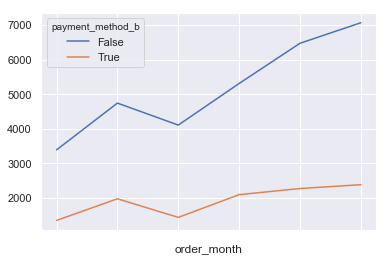

In [157]:
orders_df_flat.groupby(['order_month','payment_method_b']).user_id.nunique().unstack()[:-1].plot()
plt.show()

Probably we can assume that because the number of unique customers who use bank ticket doesn't grow with the same rate as the customers who use other payment methods, it means that we are dealing with always the same bank ticket users. <br>
However, if we take a look again at the dynamics of all order counts, we see a very similar picture:

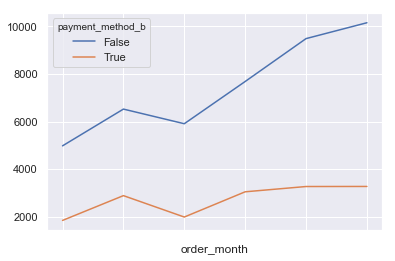

In [160]:
orders_df_flat.groupby(['order_month','payment_method_b']).id.nunique().unstack()[:-1].plot()
plt.show()

Therefore, we can't say that the number of unique bank ticket users isn't growing because there are no new customers, since the number of orders themselves grows accordingly.<br> We need to check the customer categories to be sure.
#### Comparing the share of new buyers wtih bank ticket vs. other payment methods

In [176]:
orders_df_flat.groupby('payment_method_b').is_purchase_of_new_buyer.value_counts(normalize=True).unstack().transpose()

payment_method_b,False,True
is_purchase_of_new_buyer,,
New Buyer Purchase,0.334528,0.363945
Returning Buyer Purchase,0.413289,0.530703
Same Month Returning Buyers,0.252182,0.105352


Surprisingly, even more orders are new ('New Buyer Purchase') among the purchases made with bank tickets - 36%, when compared to other payment methods - 33%. <br>
However, much less customers when using bank tickets return in the same month - only 10% vs. 25% for other payment methods. <br>
It might make sense to compare the orders made with bank tickets not with all other payment methods, but with predominantly most popular method - **Cartão**.

In [177]:
orders_df_flat.groupby('payment_method').is_purchase_of_new_buyer.value_counts(normalize=True).unstack().transpose()[['Boleto','Cartão']]

payment_method,Boleto,Cartão
is_purchase_of_new_buyer,,
New Buyer Purchase,0.363945,0.433590
Returning Buyer Purchase,0.530703,0.485199
Same Month Returning Buyers,0.105352,0.081212


When compared to **cartão**, bank ticket orders indeed have a lower share of new buyers. Importantly, the proportion of same month returning buyers is almost equal for these two most popular payment methods. <br>
These insights contribute to the idea we stated before that the customers that prefer bank tickets as a payment method have a tendency to stick to it in other purchases.

### Hypothesis 2. The customers whose bank tickets were cancelled place the next order sooner than customers whose orders with a different type of payment were cancelled.
The business sense behind this hypothesis is the following: maybe some of the customers with cancelled bank tickets have placed an order mistakinglt with this payment method, and therefore immediately placed the same one with another payment method. <br>  
Analysis based on field *days until next placed order*.

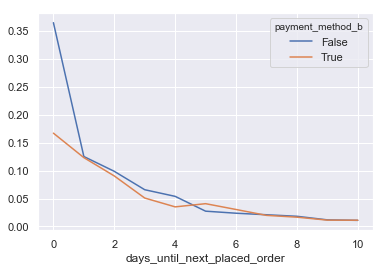

In [53]:
#Comparison of Days until next placed order for bank ticket vs. other payment methods
days_till_next = orders_df[orders_df.order_status=='CANCELLED'].groupby('payment_method_b')\
.days_until_next_placed_order.value_counts(normalize=True).unstack().fillna(value=0).transpose().head(11)
days_till_next.plot()

In [54]:
days_till_next

payment_method_b,False,True
days_until_next_placed_order,,
0.0,0.364384,0.166862
1.0,0.125114,0.123135
2.0,0.098630,0.090377
3.0,0.065753,0.050892
4.0,0.053881,0.035098
5.0,0.027397,0.040801
6.0,0.023744,0.030418
7.0,0.021005,0.019889
8.0,0.018265,0.016672


For orders with payment method other than bank ticket the share of orders placed within the same day (0) is twice as higher (36% vs 17%), which doesn't go along with the idea that maybe some customers placed their order with a bank ticket mistakingly, and than made a purchase with another payment method on the same day.<br>
It's interesting to see that the line for non-bank-ticket orders follows a clear y=k/x curve, whereas that of bank tickets has a clear break on a day 5, elevating the 

### Hypothesis 3. The customers that choose bank tickets as a payment method and don't pay them are always the same ones.

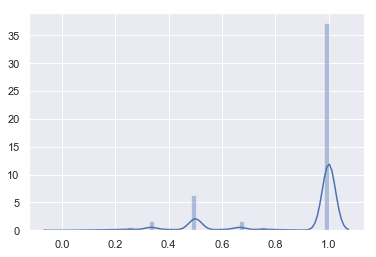

In [202]:
grouped_bc = orders_df_flat[orders_df_flat.payment_method_b==True\
                           ].groupby(['user_id']).order_status.value_counts(normalize=True)
sns.distplot(np.array(tuple(grouped_bc)))

In [ ]:
grouped_bc = orders_df_flat[orders_df_flat.payment_method_b==True].groupby(['user_id']).order_status.value_counts(normalize=True).unstack()
grouped_bc.CANCELLED.value_counts(bins=4, normalize=True)

In [ ]:
orders_df_flat[orders_df_flat.payment_method_b==True].groupby(['user_id']).order_status.value_counts(normalize = True).value_counts(normalize = True).head(15)

Most of 'boleto' purchases are either successful or not for the same customer, given that we can probably compare the properties of those customers who regularly pay well with those who don't, to see how we can hypothetically move more customers from the group of non-payers to the group of payers. <br><br>
Another way to look at this is to check the number of unique customers in each group:

In [199]:
unique_b=orders_df_flat.groupby(['order_status','payment_method_b']).user_id.nunique().unstack()
unique_b

payment_method_b,False,True
order_status,,
AWAITING PAYMENT CONFIRMATION,10.0,2.0
BILLED / READY TO BE SHIPPED,131.0,NaN
CANCELLED,1156.0,5151.0
DELIVERED,22876.0,5511.0
PAYMENT CONFIRMED,1.0,NaN
SHIPPED,715.0,3.0


In [200]:
total_b=orders_df_flat.groupby(['order_status','payment_method_b']).user_id.count().unstack()
total_b

payment_method_b,False,True
order_status,,
AWAITING PAYMENT CONFIRMATION,11.0,2.0
BILLED / READY TO BE SHIPPED,625.0,NaN
CANCELLED,1860.0,8811.0
DELIVERED,39183.0,7681.0
PAYMENT CONFIRMED,2.0,NaN
SHIPPED,3227.0,3.0


In [201]:
shares_unique = pd.concat([unique_b,total_b],axis=1,sort=False)
shares_unique.columns=['nonboleto_unique','boleto_unique','nonboleto_total','boleto_total']
shares_unique['nonboleto_share_unique']=shares_unique.nonboleto_unique/shares_unique.nonboleto_total
shares_unique['boleto_share_unique']=shares_unique.boleto_unique/shares_unique.boleto_total
shares_unique

,nonboleto_unique,boleto_unique,nonboleto_total,boleto_total,nonboleto_share_unique,boleto_share_unique
order_status,,,,,,
AWAITING PAYMENT CONFIRMATION,10.0,2.0,11.0,2.0,0.909091,1.000000
BILLED / READY TO BE SHIPPED,131.0,NaN,625.0,NaN,0.209600,NaN
CANCELLED,1156.0,5151.0,1860.0,8811.0,0.621505,0.584610
DELIVERED,22876.0,5511.0,39183.0,7681.0,0.583825,0.717485
PAYMENT CONFIRMED,1.0,NaN,2.0,NaN,0.500000,NaN
SHIPPED,715.0,3.0,3227.0,3.0,0.221568,1.000000


What we can see is that the share of unique customers among cancelled orders is not very different for customrs who pay with bank tickets vs. those who pay with another payment method (58% vs. 62%). 
On the other hand, the uniqueness of customers that make orders with bank tickets and that go through (Delivered) is slightly higher than that of non-boleto users. (72% vs. 58%). <br> We might assume that those customers that regularly use bank tickets successfully for some reason prefer to stick to bank tickets in all the further purchases, whereas among the users of other payment methods there are many eventual customers.

### Hypothesis 4. Average Order Value of orders that are paid with bank tickets and cancelled is, on average, higher than that of the other customers, making them more inclined to not paying bank tickets.

In [203]:
orders_df_flat.groupby(['payment_method_b','order_status']).order_total.mean().unstack()[['CANCELLED','DELIVERED']]

order_status,CANCELLED,DELIVERED
payment_method_b,,
False,224.219876,253.294745
True,224.666040,220.549172


Actually, the AOV of cancelled orders paid with bank tickets is amost equal to that of all other payment methods.
However, it's still lower than the AOV of orders paid by other methods. <br>

Let's see more details on all payment methods to see whether these conclusions make sense.

In [205]:
orders_df_flat.groupby(['payment_method','order_status']).order_total.mean().unstack().dropna(thresh=3)

order_status,AWAITING PAYMENT CONFIRMATION,BILLED / READY TO BE SHIPPED,CANCELLED,DELIVERED,PAYMENT CONFIRMED,SHIPPED
payment_method,,,,,,
Boleto,129.85,NaN,224.666040,220.549172,NaN,70.710000
Cartão,419.60,75.840000,419.361314,265.631837,NaN,167.958000
Cortesia Marketing,NaN,17.980000,NaN,0.000000,0.0,NaN
Débito,19.90,NaN,268.570000,205.816212,NaN,NaN
N/A,NaN,88.489655,193.992885,319.537627,NaN,147.880263
Pós-Pago,169.69,NaN,61.063840,152.555698,NaN,NaN
Visa Credito,NaN,39.900000,269.800000,271.374206,NaN,NaN


First of all, it's important to note that when it comes to cancelled orders, the AOV of bank ticket payments is actually significantly lower than that of the most common method of payment - **Cartão**. Therefore, we can't say that its the high AOV that pushes bank ticket customers to cancel their orders. <br>
Next, it's also clear to see that there is no significant difference between the AOV of cancelled and delivered orders made with bank tickets.
This hypothesis can't be accepted.

### Hypothesis 5. Orders made with bank tickets are different in terms of discounts applied

In [322]:
orders_df.groupby(['order_status','payment_method_b']).order_discount.mean().unstack().dropna()

payment_method_b,False,True
order_status,,
AWAITING PAYMENT CONFIRMATION,269.651818,0.000000
CANCELLED,18.637183,13.623206
DELIVERED,36.073022,44.279129
SHIPPED,0.025466,41.543333


For bank ticket orders, the total discount is lower in cancelled orders than it is for other payment methods, and vice-versa for Delivered orders: the discount is higher in bank ticket orders than it is in orders with other payment methods. <br> However, these differences don't appear to be significant, inviting further investigation.

### Hypothesis 6. There is a difference between bank ticket and not bank ticket orders in terms of profit margin
Let's first calculate the average profit margin per order.
For that, first calculate the profit margin per sku in each order. Note that the promotional price of each item is used, since what is interesting here is the actual profitability of each item in an order.

In [22]:
#create a field 'profit margin' in the Order Items table:
oi_df['profit_margin'] = (oi_df.promotional_price-oi_df.product_cost)/oi_df.promotional_price
oi_df[['order_id','sku','promotional_price','product_cost','profit_margin']].head()

,order_id,sku,promotional_price,product_cost,profit_margin
0,1594409,2195_73_0_M,257.98,79.53,0.691720
1,1594409,2881_147_0_M,211.03,102.44,0.514571
2,1594409,4097_263_0_G,175.82,75.10,0.572859
3,1594409,5403_1000026_0_U,117.14,37.54,0.679529
4,1652797,2967_1000058_0_M,174.23,117.15,0.327613


In [23]:
#Due to division there might appear some infinities in the dataset. Let's replace them with NaN:
oi_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [24]:
#create a dataframe with average order profit margin for each order:
pm = oi_df.groupby('order_id').profit_margin.mean().rename('order_profit_margin').to_frame()
pm.head()

,order_profit_margin
order_id,
1514142,0.664510
1514153,0.671091
1514164,0.661108
1514175,0.490940
1514186,0.648448


In [25]:
#merge the created dataframe into the orders dataframe:
orders_df_flat = orders_df_flat.merge(pm, left_on='id', right_on = 'order_id')

In [26]:
#the profit margins have been assigned in field 'order_profit_margin_y'
#Let's now compare the average profit margins across the categories of interest:
orders_df_flat.groupby(['order_status','payment_method_b']).order_profit_margin.mean().unstack().dropna()

payment_method_b,False,True
order_status,,
AWAITING PAYMENT CONFIRMATION,0.572898,0.367881
CANCELLED,0.508031,0.531920
DELIVERED,0.594828,0.523161
SHIPPED,0.674325,0.620778


The results are pretty similar to those that we saw in the AOV analysis: when it comes to cancelled orders, the orders paid with bank tickets appear to have had a slightly higher profit margin. However, when we compare successful orders - those with status **Delivered**, non-bank ticket orders seem to have a slightly higher average profit margin.<br>
In whatever case, the differences don't appear to be very suspicious and might turn out to be due to variation in the sample.

### Hypothesis 7. Bank tickets are more common in certain states of Brazil
Analysis based on field *address state*. For simplicity, I assume that for the majority of orders the address to which the customers is ordering delivery is located in the same state where the customer himself.

In [27]:
orders_df_flat.groupby('address_state').payment_method_b.value_counts(normalize=True).unstack()

payment_method_b,False,True
address_state,,
,1.000000,NaN
AC,0.500000,0.500000
AL,0.686131,0.313869
AM,0.643939,0.356061
AP,0.323810,0.676190
BA,0.622544,0.377456
CE,0.645161,0.354839
DF,0.694364,0.305636
ES,0.464385,0.535615


We can note that in São Paulo (**SP**), bank ticket usage is the least (20%), and in Amapá (**AP**), it's the largest - 68%.<br>
Given the idea analyzed above that the customers generally prefer to use the same payment method (either bank ticket or other) for their different orders, we might come to conclusion that customers from different states need a different approach, maybe a customized user experience on the website, depending on their preferred payment method.

### Hypothesis 8. Bank ticket cancellations are more common in certain times of the day
Let's take a look at cancellation rates of orders made in different times of the day with bank tickets as opposed to other payment methods.

order_raw,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cancel_rate_b,0.520992,0.619910,0.656863,0.661538,0.666667,0.685185,0.712644,0.551887,0.550622,0.507661,...,0.513465,0.506714,0.531109,0.531996,0.551681,0.573034,0.567282,0.554278,0.547074,0.563771
cancel_rate_nb,0.093727,0.029891,0.011429,0.049383,NaN,0.040000,0.023810,0.008824,0.019715,0.025740,...,0.020273,0.031014,0.031825,0.028823,0.029006,0.023342,0.017837,0.021024,0.014781,0.017361


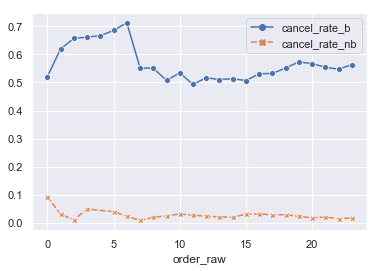

In [56]:
#Cancellation rate of bank ticket orders, by hour:
cancel_rate_hour_b = orders_df_flat[orders_df_flat.payment_method_b==True]\
.groupby(pd.DatetimeIndex(orders_df_flat[orders_df_flat.payment_method_b==True]\
                          .order_raw).hour).order_status.value_counts(normalize=True).unstack().transpose().loc['CANCELLED']

#Cancellation rate of orders made by other payment methods, by hour:
cancel_rate_hour_nb = orders_df_flat[orders_df_flat.payment_method_b==False]\
.groupby(pd.DatetimeIndex(orders_df_flat[orders_df_flat.payment_method_b==False].order_raw).hour).\
order_status.value_counts(normalize=True).unstack().transpose().loc['CANCELLED']

cancel_rate_hour = pd.concat([cancel_rate_hour_b,cancel_rate_hour_nb], axis=1, sort=False)
cancel_rate_hour.columns = ['cancel_rate_b','cancel_rate_nb']

sns.lineplot(markers=True, data=cancel_rate_hour, legend="full")
cancel_rate_hour.transpose()

It appears that there is quite a large fluctuation in the cancellation rate during the night time for the orders made with bank tickets. With the cancellation rate hitting its absolute maximum at 6 am - 71%, and being on an increasingly high level during the hours 2-5 am. <br>
    All other methods of payment, on the other hand, don't follow this same pattern. The cancellation rate for them is slightly higher at the night time, but we can't observe such a visible peak like in orders paid by bank tickets.

### Hypothesis 9. (not finished) Customers whose first placed order was bank ticket never come back more frequently as opposed to customers whose first placed order was any other payment method.

In [ ]:
orders_df.xs(1,level='rn').groupby('order_status').payment_method_b.value_counts().unstack()

In [ ]:
orders_df.groupby('order_status').payment_method_b.value_counts().unstack()

In [ ]:
#select all users whose first placed orders that were cancelled
users_1canc=list(orders_df.xs(1,level='rn')[orders_df.xs(1,level='rn').order_status=='CANCELLED'].index.values)
users_1canc

In [ ]:
#не вышло
orders_df['payment_method_1canc']=np.where(pd.Series(orders_df.index.get_level_values('user_id')).isin('users_1canc'))
#list(orders_df.index.get_level_values('user_id'))

In [ ]:
#orders_df_flat
orders_df_flat['payment_method_first_order_b']=np.where(orders_df_flat['user_id'].isin(users_1canc),True,False)
orders_df_flat#.groupby(['payment_method_first_order_b','rn']).rn.count()

In [ ]:
#orders_df['payment_method_first_order_b']=np.where(orders_df['payment_method']=="Boleto",True,False)

orders_df['payment_method_first_order_b']\
=np.where(orders_df.xs(1,level='rn')[orders_df.xs(1,level='rn').\
                                         order_status=='CANCELLED']['payment_method']=="Boleto",True,False)